In [11]:
from exp.utils import *
from exp.models import *
from exp.losses import *
from fastai.vision.all import *

In [12]:
p_train_valid = get_data_path()/"train_valid_images"
device = get_device()
DROPCOLS = ["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                       "View Position", "OriginalImage[Width", "Height]", 
                       "OriginalImagePixelSpacing[x", "y]", "No Finding"]

Using the GPU!


In [13]:
labels = sorted(get_labels())

In [14]:
def get_dfs(label):
    train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                                 small=False)
    #print(train_df.shape, valid_df.shape, test_df.shape)
    train_df = get_binary_df(label, train_df)
    valid_df = get_binary_df(label, valid_df)
    test_df  = get_binary_df(label, test_df)

    complete_df = pd.concat([train_df, valid_df, test_df])
    complete_df = complete_df.drop(columns=["Follow-up #", "Patient ID", "Patient Age", "Patient Gender", 
                       "View Position", "OriginalImage[Width", "Height]", 
                       "OriginalImagePixelSpacing[x", "y]", "No Finding"])
    return train_df, valid_df, complete_df

def get_label_func(label):
    return partial(partial_label_func, label)

def partial_label_func(label, fname):
    lbl = complete_df[complete_df["Image Index"] == fname.name][label].values[0]
    return "Pos" if lbl > 0 else "Neg"

def splitter_func(fn):
    return fn.parent.stem == "valid_images" 

def get_weights(label):
    train_label = train_df[[label]].values
    neg_weights, pos_weights = compute_class_freqs(train_label)
    neg_weights, pos_weights = torch.Tensor(neg_weights), torch.Tensor(pos_weights)
    weights = torch.Tensor([neg_weights, pos_weights]).to(device)
    return weights

def get_dls(bs, image_size, path=p_train_valid):
    batch_tfms = [Brightness(), 
                  Contrast(),
                  RandomErasing(p=.25, max_count=2)] 
    
    dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                       get_items = get_image_files,
                       get_y     = label_func,
                       splitter  = FuncSplitter(splitter_func),
                       item_tfms = [Resize(image_size, 
                                          method="squish", 
                                          pad_mode="zeros")],
                       batch_tfms = batch_tfms)
    return dblock.dataloaders(path, bs=bs)

def namify(label):
    return "".join(label.split(" ")).lower()

In [10]:
SplitFunc()

NameError: name 'SplitFunc' is not defined

Training Atelectasis...


epoch,train_loss,valid_loss,accuracy,roc_auc_score,time
0,0.393615,0.411478,0.894764,0.660686,02:45
1,0.404360,0.527134,0.786003,0.652010,02:46
2,0.394227,0.397672,0.900139,0.674885,02:46
3,0.386131,0.404694,0.900312,0.695823,02:45
4,0.386948,0.394105,0.900312,0.715064,02:46
5,0.392158,0.390165,0.900254,0.722311,02:46
6,0.382161,0.383599,0.900312,0.746428,02:46
7,0.381047,0.384399,0.900370,0.744644,02:46
8,0.384532,0.383185,0.900081,0.755413,02:47
9,0.384521,0.382409,0.900428,0.763436,02:47


Better model found at epoch 0 with valid_loss value: 0.4114777743816376.


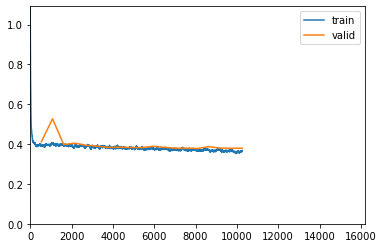

Better model found at epoch 2 with valid_loss value: 0.39767181873321533.
Better model found at epoch 4 with valid_loss value: 0.3941051959991455.
Better model found at epoch 5 with valid_loss value: 0.39016467332839966.
Better model found at epoch 6 with valid_loss value: 0.38359907269477844.
Better model found at epoch 8 with valid_loss value: 0.38318488001823425.
Better model found at epoch 9 with valid_loss value: 0.3824092149734497.
Better model found at epoch 12 with valid_loss value: 0.37956860661506653.
Better model found at epoch 14 with valid_loss value: 0.37799713015556335.


IndexError: list index out of range

In [5]:
for label in labels:
    print(f"Training {label}...")
    # Setup
    train_df, valid_df, complete_df = get_dfs(label)
    label_func = get_label_func(label)
    #weights = get_weights(label)
    model_name = f"xresnet50_finetuned_{namify(label)}_v1"
    
    # Callbacks
    sched = {'lr': SchedExp(3e-3, 1e-9)}
    callbacks = [
        ParamScheduler(sched),
        EarlyStoppingCallback(monitor="valid_loss",
                              patience=20),
        SaveModelCallback(monitor="valid_loss", 
                          fname=model_name, 
                          with_opt=True),
        ShowGraphCallback(), 
        MixUp()
    ]
    
    # First increment
    dls = get_dls(bs=128, image_size=64)
    model = xresnet50(n_out=dls.c)
    learn = Learner(dls, 
                    model, 
                    loss_func=LabelSmoothingCrossEntropy(),
                    metrics=[accuracy, RocAucBinary()],
                    cbs=callbacks)
    learn.fit_one_cycle(30)
    
    # Second increment
    learn.load(Path().cwd()/"models"/model_name)
    learn.dls = get_dls(bs=64, image_size=128)
    learn.fit_one_cycle(30)
    
    # Final increment
    learn.load(Path().cwd()/"models"/model_name)
    learn.dls = get_dls(bs=64, image_size=224)
    learn.fit_one_cycle(30)

In [11]:
learn.model

XResNet(
  (0): ConvLayer(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (1): ConvLayer(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (2): ConvLayer(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): ResBlock(
      (convpath): Sequential(
        (0): ConvLayer(
          (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

In [10]:
learn.opt.frozen_idx

0

In [4]:
train_df, valid_df, test_df = get_dataframes(include_labels=get_labels(), 
                                                 small=False)

In [8]:
get_labels()

['Edema',
 'Effusion',
 'Nodule',
 'Mass',
 'Atelectasis',
 'Cardiomegaly',
 'Pleural_Thickening',
 'Consolidation',
 'Pneumothorax',
 'Pneumonia',
 'Fibrosis',
 'Hernia',
 'Emphysema',
 'Infiltration']

In [7]:
train_df.drop(columns=DROPCOLS)

,Image Index,Pneumothorax,Nodule,Consolidation,Hernia,Infiltration,Pneumonia,Mass,Cardiomegaly,Effusion,Pleural_Thickening,Fibrosis,Emphysema,Edema,Atelectasis
82650,00020326_000.png,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82651,00020326_001.png,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82652,00020326_002.png,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
82653,00020326_004.png,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
82654,00020326_003.png,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112063,00030764_000.png,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
112078,00030774_000.png,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112100,00030789_000.png,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
112106,00030793_000.png,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
batch_tfms = [Brightness(), 
              Contrast(),
              RandomErasing(p=.25, max_count=2)] 

dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = FuncSplitter(splitter_func),
                   item_tfms = [Resize(image_size, 
                                      method="squish", 
                                      pad_mode="zeros")],
                   batch_tfms = batch_tfms)
dls = dblock.dataloaders(p_train_valid, bs=64)